In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
!conda run -n base python3 -m pip install -q git+https://github.com/landerlini/FastQuantileLayer.git --force-reinstall --no-deps


2022-12-03 21:18:31.188075: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_dataset = tf.data.experimental.load("./acceptance-train.tfrecords")
validation_dataset = tf.data.experimental.load("./acceptance-validation.tfrecords").batch(1000)

X, y = next(iter(train_dataset.batch(100000)))

2022-12-03 21:18:38.324475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from FastQuantileLayer import FastQuantileLayer
layers = [FastQuantileLayer(output_distribution='normal', trainable=True).fit(X)]
layers += [tf.keras.layers.Dense(128, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.01)) for _ in range(10)]

model = tf.keras.models.Sequential()
for layer in layers:
    model.add(layer)
model.add(tf.keras.layers.Dense(1, activation='softmax'))
model.build(input_shape = [None, X.shape[1]])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fast_quantile_layer (FastQu  (None, 10)               0         
 antileLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                        

In [4]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop


In [5]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.01), optimizer=RMSprop(1e-2))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
data = train_dataset.batch(100_000).prefetch(tf.data.AUTOTUNE)
history = model.fit(data, epochs=50, validation_data=next(iter(validation_dataset)), callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 9s 940ms/step - loss: 20.8800 - val_loss: 13.3057
Epoch 2/50
7/7 [==============================] - 6s 815ms/step - loss: 10.6766 - val_loss: 7.4596
Epoch 3/50
7/7 [==============================] - 6s 846ms/step - loss: 6.1736 - val_loss: 4.9528
Epoch 4/50
7/7 [==============================] - 7s 898ms/step - loss: 4.0063 - val_loss: 2.8664
Epoch 5/50
7/7 [==============================] - 6s 818ms/step - loss: 2.3958 - val_loss: 1.7927
Epoch 6/50
7/7 [==============================] - 7s 878ms/step - loss: 1.5166 - val_loss: 1.2215
Epoch 7/50
7/7 [==============================] - 6s 761ms/step - loss: 1.0864 - val_loss: 0.9511
Epoch 8/50
7/7 [==============================] - 6s 847ms/step - loss: 0.8780 - val_loss: 0.8165
Epoch 9/50
7/7 [==============================] - 6s 862ms/step - loss: 0.7722 - val_loss: 0.7447
Epoch 10/50
7/7 [==============================] - 6s 799ms/step - loss: 0.7140 - val_loss: 0.7028
Epoch 11/50
7/7 

In [6]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
data = train_dataset.batch(100_000).prefetch(tf.data.AUTOTUNE)
history_ft = model.fit(data, epochs=50, validation_data=next(iter(validation_dataset)), callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 12s 942ms/step - loss: 1.0981 - val_loss: 0.8947
Epoch 2/50
7/7 [==============================] - 6s 848ms/step - loss: 0.8344 - val_loss: 0.7813
Epoch 3/50
7/7 [==============================] - 7s 888ms/step - loss: 0.7424 - val_loss: 0.7131
Epoch 4/50
7/7 [==============================] - 6s 877ms/step - loss: 0.6870 - val_loss: 0.6770
Epoch 5/50
7/7 [==============================] - 6s 843ms/step - loss: 0.6579 - val_loss: 0.6585
Epoch 6/50
7/7 [==============================] - 6s 864ms/step - loss: 0.6427 - val_loss: 0.6492
Epoch 7/50
7/7 [==============================] - 6s 817ms/step - loss: 0.6349 - val_loss: 0.6448
Epoch 8/50
7/7 [==============================] - 6s 760ms/step - loss: 0.6312 - val_loss: 0.6427
Epoch 9/50
7/7 [==============================] - 6s 827ms/step - loss: 0.6295 - val_loss: 0.6418
Epoch 10/50
7/7 [==============================] - 6s 862ms/step - loss: 0.6288 - val_loss: 0.6414
Epoch 11/50
7/7 [=

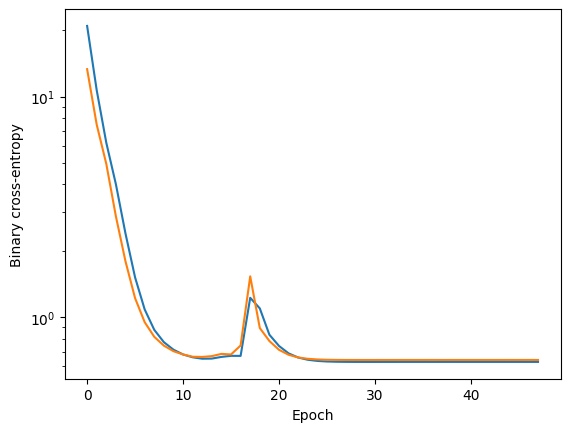

In [7]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('log')
plt.show()

In [8]:
help(RMSprop)

Help on class RMSprop in module keras.optimizers.optimizer_v2.rmsprop:

class RMSprop(keras.optimizers.optimizer_v2.optimizer_v2.OptimizerV2)
 |  RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop', **kwargs)
 |  
 |  Optimizer that implements the RMSprop algorithm.
 |  
 |  The gist of RMSprop is to:
 |  
 |  - Maintain a moving (discounted) average of the square of gradients
 |  - Divide the gradient by the root of this average
 |  
 |  This implementation of RMSprop uses plain momentum, not Nesterov momentum.
 |  
 |  The centered version additionally maintains a moving average of the
 |  gradients, and uses that average to estimate the variance.
 |  
 |  Args:
 |    learning_rate: A `Tensor`, floating point value, or a schedule that is a
 |      `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
 |      that takes no arguments and returns the actual value to use. The
 |      learning rate. Defaults to 0.001.
 |    rho: 